### Initialise

In [255]:
## Import necessary packages
import matplotlib.pyplot as plt; 
import numpy as np; 
from sklearn.linear_model import SGDRegressor;
from sklearn.metrics import mean_squared_error, accuracy_score;
from sklearn.model_selection import train_test_split,cross_val_score;
import torch;

import python.data as datameta

In [256]:
# Basic Initialisations
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


### Preprocess Data

In [257]:
data = datameta.processData('data/clean_data.csv'); 
data.head()

Index(['Time (h)', 'Aeration rate(Fg:L/h)', 'Sugar feed rate(Fs:L/h)',
       'Acid flow rate(Fa:L/h)', 'Base flow rate(Fb:L/h)',
       'Heating/cooling water flow rate(Fc:L/h)',
       'Heating water flow rate(Fh:L/h)',
       'Water for injection/dilution(Fw:L/h)',
       'Air head pressure(pressure:bar)', 'Substrate concentration(S:g/L)',
       'Penicillin concentration(P:g/L)', 'Vessel Volume(V:L)', 'pH(pH:pH)',
       'Temperature(T:K)', 'PAA flow(Fpaa:PAA flow (L/h))',
       'Oil flow(Foil:L/hr)', 'Oxygen Uptake Rate(OUR:(g min^{-1}))',
       'Ammonia shots(NH3_shots:kgs)',
       '0 - Recipe driven 1 - Operator controlled(Control_ref:Control ref)'],
      dtype='object') 

 (113935, 19)


,Time (h),Aeration rate(Fg:L/h),Sugar feed rate(Fs:L/h),Acid flow rate(Fa:L/h),Base flow rate(Fb:L/h),Heating/cooling water flow rate(Fc:L/h),Heating water flow rate(Fh:L/h),Water for injection/dilution(Fw:L/h),Air head pressure(pressure:bar),Substrate concentration(S:g/L),Penicillin concentration(P:g/L),Vessel Volume(V:L),pH(pH:pH),Temperature(T:K),PAA flow(Fpaa:PAA flow (L/h)),Oil flow(Foil:L/hr),Oxygen Uptake Rate(OUR:(g min^{-1})),Ammonia shots(NH3_shots:kgs),0 - Recipe driven 1 - Operator controlled(Control_ref:Control ref)
0,0.000000,0.181818,0.040541,0.000000,0.133858,0.006556,0.0,0.0,0.0,0.008306,1.791808e-27,0.049276,0.767126,0.258427,0.333333,0.0,0.215230,0.0,0.0
1,0.000690,0.181818,0.040541,0.000000,0.227649,0.012103,0.0,0.0,0.0,0.008715,2.763729e-05,0.049480,0.800686,0.249064,0.333333,0.0,0.162455,0.0,0.0
2,0.001380,0.181818,0.040541,0.000000,0.241342,0.006399,0.0,0.0,0.0,0.009107,2.761905e-05,0.049685,0.836653,0.243446,0.333333,0.0,0.150004,0.0,0.0
3,0.002070,0.181818,0.040541,0.000000,0.168071,0.002893,0.0,0.0,0.0,0.009492,2.760247e-05,0.049787,0.860582,0.237828,0.333333,0.0,0.148100,0.0,0.0
4,0.002761,0.181818,0.040541,0.039866,0.084036,0.000736,0.0,0.0,0.0,0.009864,2.758782e-05,0.049838,0.865835,0.234082,0.333333,0.0,0.148945,0.0,0.0


In [258]:
# Split into x and y
x_keys = [
    "Time (h)", "Aeration rate(Fg:L/h)", "Sugar feed rate(Fs:L/h)","Acid flow rate(Fa:L/h)",
    "Base flow rate(Fb:L/h)","Heating/cooling water flow rate(Fc:L/h)","Heating water flow rate(Fh:L/h)",
    "Water for injection/dilution(Fw:L/h)","Substrate concentration(S:g/L)","PAA flow(Fpaa:PAA flow (L/h))",
    "Oil flow(Foil:L/hr)", "Oxygen Uptake Rate(OUR:(g min^{-1}))", "Ammonia shots(NH3_shots:kgs)",
    # Converted variables
    "0 - Recipe driven 1 - Operator controlled(Control_ref:Control ref)",
    "Air head pressure(pressure:bar)", "Temperature(T:K)", "pH(pH:pH)", "Vessel Volume(V:L)"
]
(x,y) = datameta.xy_split(data,x_keys)

18  keys in  18 cols
1  keys in  1 cols


In [259]:
xtrain, xtest, ytrain, ytest=train_test_split(x, y, test_size=0.1)
sgdr = SGDRegressor(loss='squared_error')
print(sgdr)

SGDRegressor()


In [260]:
sgdr.fit(xtrain, ytrain.values.ravel())

score = sgdr.score(xtrain, ytrain)
print("R-squared:", score)

cv_score = cross_val_score(sgdr, x, y.values.ravel(), cv=13)
print("CV mean score: ", cv_score.mean())

R-squared: 0.8687134508230501
CV mean score:  -118114588.21137871


In [261]:
ypred = sgdr.predict(xtest)

mse = mean_squared_error(ytest, ypred)
print("RMSE: ", mse) # RMSE:  5.989717348642267e-08 


def isClose(base, known, tol):
    return np.abs((base - known) / base) <= tol

accuracy = np.sum(isClose(ypred[0], ytest.to_numpy(), 0.1))/len(ypred)
print(accuracy*100, "%")

RMSE:  0.010172799341184355
11.0 %


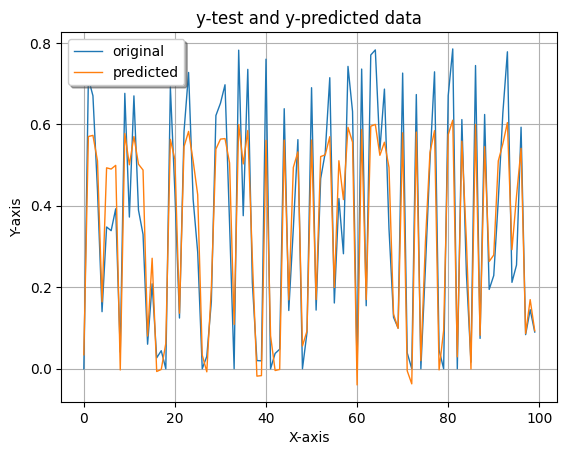

In [238]:

x_ax = range(len(ytest))
plt.plot(x_ax, ytest, linewidth=1, label="original")
plt.plot(x_ax, ypred, linewidth=1, label="predicted")
plt.title("y-test and y-predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 
